#### Vít Škvára - Samoorganizace a dolování dat/Self-organization and data mining

# Kernel methods for multiple-instance learning problem

In this protocol, we explore the possibily of using kernel methods, namely smallest enclosing hypersphere, for the task of anomaly detection under the multiple-instance learning paradigm.

## Multiple-instance learning (MIL)

In multiple-instance learning (MIL), the problem of supervised binary classification is made more difficult for the learner due to a number of reasons. Firstly, instead of having a set of instances (feature vectors) labeled as negative or positive, a number of _bags_ of instances is received, where the whole bags are labeled as positive or negative. Every bag consists of a (possibly different) number of instances whose individual labels are not known. The common conception is that a bag is labeled negative if all instances in it are negative, but if even a single instance is positive, then the label of the bag is also positive. Secondly, the ratio of negative to positive instances in a bag can be arbitrarily high. In real-world problems however, this presumption can be violated and positive and negative bags may be generated from entirely different sources. 

Our motivation comes from the area of malware detection in computers connected to a network whose activity is supervised. In such a case, the communication of every computer with the outside world (using a HTTP protocol) goes through a common hub. The observer, for a limited time frame, collects all HTTP requests of the computers in the network. From each request, we substract a number of features (e.g. bytes sent and received, request lenght in ms). A collection of such instances for one computer creates a bag. Additionaly, some computers are known to be infected with malware that communicates with the Internet. Their bags are then labeled as positive and together with bags of some uninfected computers compose a training dataset. Presumably, positive bags should contain a number of positive instances - requests created by the malware. 

## Kernel theory basics

Firstly, we will give a brief introduction to kernel methods and the smallest hypersphere algorithm that will be used to detect outliers or anomalies. A kernel is a mapping
\begin{equation}
    \kappa(x,y) = \langle \phi(x), \phi(y) \rangle
\end{equation}
that encodes data $x,y \in \mathcal{X}$ to feature space $\mathcal{F}$ using a scalar product of an embedding map 
\begin{equation}
    \phi:\mathcal{X} \rightarrow \mathcal{F}.
\end{equation}

The trick of kernel methods is that for a training dataset $X= \lbrace x_1, x_2, \dots, x_m \rbrace$, they are able to use standar linear machine learning techniques on the richer feature space $\mathcal{F}$ without directly computing the potentially computationally demanding mapping $\phi(x_i), i = 1, 2, \dots, m$. Instead, it is sufficient to obtain the kernel matrix $G$, which satistfies 
\begin{equation}
    G_{ij} = \kappa(x_i,x_j) = \langle \phi(x_i), \phi(x_j) \rangle.
\end{equation}
This matrix is symmetric and enables us to use a large number of classical algorithms in the feature space.

The quadratic kernel is one of the simplest. It is defined as 
\begin{equation}
    \kappa(x,y) = \langle x, y \rangle^2
\end{equation}
and its corresponding feature map for $\mathcal{X} = \mathbb{R}^2$ is 
\begin{equation}
    \phi(x) = (x_1^2, x_2^2, \sqrt{2}x_1x_2) 
\end{equation}
embeds the original samples to feature space $\mathcal{F} = \mathbb{R}^3$.



## Experiment 1

We will implement the smallest enclosing sphere algorithm and test it on a simple benchmark problem. 

Firstly, we generate the data and create the kernel.

In [1]:
# here, the required libraries are loaded
using Convex, SCS # for optimization
import Convex.norm2
using ClobberingReload # for deprecation warnings supression
using PyPlot # for plots

We generate a training and a testing dataset in $\mathbb{R}^2$.

In [2]:
m = 2 # problem dimension
c_data = [1,4] # the data will be offset by this
n_train = 20 # no training samples
X_train = randn(2,n_train) .+ c_data

n_test = 10
X_test = randn(2,n_test) .+ c_data
A = randn(2, n_test)*10 .+ c_data 
X_test = cat(2, X_test, A);

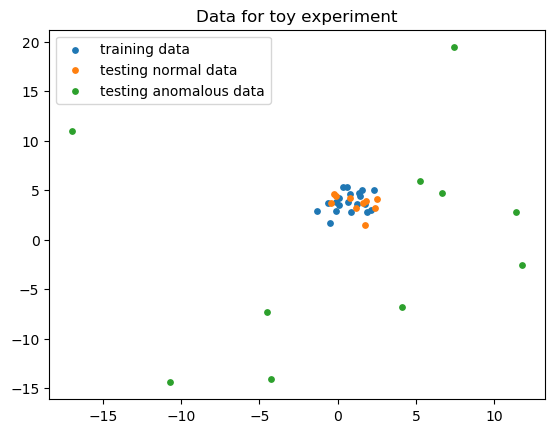

In [3]:
f = figure()
ss = 15
scatter(X_train[1,:], X_train[2,:], s=ss, label = "training data")
scatter(X_test[1,1:n_test], X_test[2,1:n_test], s = ss, 
    label = "testing normal data")
scatter(X_test[1,n_test+1:end], X_test[2,n_test+1:end], s = ss,
    label = "testing anomalous data")
legend()
title("Data for toy experiment");

We will use the quadratic kernel as the generating function has quite a simple form. We will use the form with offset
\begin{equation}
    \kappa(x,y) = (\langle x, y \rangle + c)^2
\end{equation}
which has a feature map
\begin{equation}
    \varphi(x) = \left( x_1^2, \ldots, x_m^2, \sqrt{2} x_1 x_{2}, \ldots, \sqrt{2} x_1 x_m, \sqrt{2} x_2 x_3, \ldots, \sqrt{2} x_2 x_m, \ldots, \sqrt{2} x_{m-1} x_{m}, \sqrt{2c} x_1, \ldots, \sqrt{2c} x_m, c \right)
\end{equation}
We know that the resulting feature space $\mathcal{F}$ has dimension ${m+2\choose 2} = 6$ for $m=2$. 

Below, the feature map for a quadratic kernel and a sample space of arbitrary dimension is implemented.

In [4]:
"""
    quadmap(x, c = 0.0)

Is the feature map for quadratic kernel.
"""
function quadmap{T<:Real}(x::AbstractArray{T,1}, c = 0.0)
    m = length(x)
    nq = binomial(m+2,2)
    
    # decrease the resulting dimension if c is zero
    if c == 0
        nq -= (m+1)
    end
    
    # create the resulting array
    res = zeros(nq)
    
    # first the solo quadratic coefficients
    res[1:m] = x.^2
    
    # now the cross-quadratics
    k = 1+m
    for i in 1:m
        for j in 1:(m-i) 
           res[k] = sqrt(2)*x[i]*x[j]
            k += 1
        end
    end
    
    if c != 0
        # now the linear elements
        for i in 1:m
           res[k] = sqrt(2*c)*x[i]
            k += 1
        end

        # now the final constant
        res[end] = c
    end
    
    return res
end

# version for 2D arrays
quadmap{T<:Real}(x::AbstractArray{T,2}, c = 0.0) = 
    mapslices(y -> quadmap(y,c), x, 1)

quadmap (generic function with 4 methods)

Below here, the type representing the quadratic kernel is implemented along with a constructor. The constructor is called with data $X$ and offset $c$ (which has a default value of 0). It computes and stores the kernel matrix and initializes the feature map. Also, an object of type `quadkernel` can be called directly as `quadkernel(x,y)` or `quadkernel(x)` to obtain the value for vectors `x,y`.

Implementation remark: for quadratic kernel and $m<3$, the kernel matrix may not be numerically positive definite, so we add a small number to its diagonal. This has the same effect as adding noise to training samples.

In [5]:
# abstract kernel type
abstract type kernel
end

# quadratic kernel type
struct quadkernel <: kernel
    X # the data matrix
    km # kernel matrix
    ϕ # feature map
    c
end

# constructor
quadkernel(X, c=0) = quadkernel(X, 
    (X'*X .+ c).^2 + eye(size(X,2))*1e-8, # here the noise is added 
    x -> quadmap(x,c), # the feature map is fixed with given c
    c)

# overloaded for direct calling
(qk::quadkernel)(x,y) = (x'*y + qk.c).^(2)
(qk::quadkernel)(x) = qk(x,x)

Now we initialize a new object of type `quadkernel` with the training data. We set $c=0$. Also, we visualize the kernel matrix after initialization.

In [6]:
qk = quadkernel(X_train)
qk.km

20×20 Array{Float64,2}:
 187.841   271.436   169.753   216.021   …  412.879   114.902   126.456
 271.436   469.051   354.245   344.55       661.732   240.16    273.189
 169.753   354.245   315.9     240.15       463.554   214.436   250.403
 216.021   344.55    240.15    262.216      502.516   162.703   182.578
 166.381   313.341   256.212   221.78       426.927   173.806   200.266
 180.673   308.629   230.503   227.856   …  437.478   156.255   177.415
  97.1439  236.787   237.352   150.748      292.172   161.251   191.521
  36.4086  121.217   147.432    68.6178     134.054   100.289   122.215
 288.372   584.331   508.705   401.005      773.444   345.253   401.699
 300.065   526.125   402.915   384.029      737.844   273.186   311.47 
 248.092   469.745   385.93    331.72    …  638.655   261.812   301.895
  75.3082  164.754   152.497   109.543      211.712   103.545   121.583
 102.784   179.082   136.322   131.076      251.797    92.4247  105.273
 297.09    584.881   497.013   406.266  

## The smallest enclosing hypersphere algorithm

The idea of the algorithm is finding a smallest enclosing hypersphere of the training dataset $X$ in feature space $\mathcal{F}$ that is defined by center $c \in \mathcal{F}$ and radius $r\in \mathbb{R}$. This translates to a nonlinear optimization problem for an unknown weight vector $\alpha \in \mathbb{R}^n$ defined as
$$
    \max_{\alpha} W(\alpha) = \alpha^T \text{diag}(G) - \alpha^T G\alpha
$$
$$
    \text{s.t.} \sum_{i=1}^n \alpha_i = 1, \alpha_i \geq 0, i = 1, \dots, n
$$
where $\text{diag}(G)$ is a vector containing the diagonal elements of $G$.

Let $\alpha^*$ denote the found optimal solution. Then the following holds
$$
    r^* = \sqrt{W(\alpha^{*})}
$$
$$
    c^* = \sum_{i=1}^n \alpha_i^* \phi(x_i)
$$
where $r^*, c^*$ are the radius and center of the smallest sphere that contains all the training data.

For a new sample $x$, the testing function that determines whether the point lies inside or outside the sphere has the following  form
$$
    f(x) = \kappa(x,x) - 2 \sum_{i=1}^n \alpha_i^* \kappa(x_i,x) + D,
$$
$$
    D = \alpha^{*T} G \alpha^* - r^{*2}.
$$
If $f(x) \geq 0$, then the sample lies inside the sphere, otherwise it is outside.

Note that for the computation of the testing function, the exact form  of the feature map $\phi(x)$ is not needed as it is not required here.


The type `kernel_sh` contains the basic building blocks for the smallest enclosing hypersphere algorithm. It contains the kernel (which is again a structure containing kernel matrix, feature map and parameters of the kernel) and parameters of the algorithm: $\alpha^*, r^*, D$ and $c^*$. The constructor is called using a structure of type `kernel`.

In [7]:
# kernelized smallest hypersphere for anomaly detection
mutable struct kernel_sh
    k::kernel # kernel
    α # alpha
    r # hypersphere radius
    D # D constant
    c # hypersphere center
    opt::Bool # was the solution already found?
end

# constructor
kernel_sh(k::kernel) = 
    kernel_sh(k, Array{Float64,1}([]), NaN, NaN, NaN, false)

kernel_sh

The following functions and methods for the `kernel_sh` type implement  $W(\alpha)$, testing function $f(x)$ and the optimization method to find $\alpha^*$. To solve the maximisation problem with linear constraints we use the `Convex` package with `SCS - Splitting Convex Solver`.

In [59]:
W(α,gm) = diag(gm)'*α - sum(gm.*(α*α'))
W(ksh::kernel_sh) = W(ksh.α, ksh.k.km)

function find_sphere!(ksh::kernel_sh)
    # this is the optimization part using Convex and SCS packages
    # setup the variables, objective and constraints
    n = size(ksh.k.km,1)
    α = Variable(n, Positive())
    dkm = diag(ksh.k.km)'
    km = ksh.k.km
    objective = dkm*α - quadform(α, km)
    constraints = [sum(α) == 1.0]
    problem = maximize(objective, constraints) 
    # solve
    no_warnings() do
        solve!(problem)
    end
    # if succesfully solved, extract and round the optimal solution
    if problem.status == :Optimal
        ksh.α = round.(problem.solution.primal[1:n], 3)
        ksh.opt = true
    else
        error("Optimal α not found!")
    end
    
    # compute the radius
    ksh.r = sqrt(W(ksh))
    # compute D for the anomaly score function
    ksh.D = ksh.α'*ksh.k.km*ksh.α - ksh.r^2
    # compute the center - but we don't really need this
    # but for the 2D case it is possible
    if !(ksh.k.ϕ == nothing)
        ksh.c = ksh.k.ϕ(ksh.k.X)*ksh.α
    end
    
    return 
end

"""
    anomaly_score(ksh::kernel_sh, x)

This computes the anomaly score/testing function given a kernel 
hypersphere and a sample x.
"""
function anomaly_score(ksh::kernel_sh, x)
    if ksh.opt
        return ksh.k(x) - 2*ksh.α'*ksh.k(ksh.k.X, x) + ksh.D
    else
        warn("The optimum value was not yet found!")
        return NaN
    end
end

"""
    anomaly_score(ksh::kernel_sh, x)

This computes the anomaly score/testing function given a kernel 
hypersphere and a sample x.
"""
function anomaly_score{T<:Real}(ksh::kernel_sh, x::AbstractArray{T,2})
    return [anomaly_score(ksh, x[:,i]) for i in 1:size(x,2)]
end

anomaly_score

Initialize an instance of the `kernel_sh` type using the previously created quadratic kernel and compute the enclosing hypersphere. The output of the splitting conic solver is printed.

In [9]:
# initialize the object
ksh = kernel_sh(qk)
# and find the optimal alpha
find_sphere!(ksh)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 466
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 23, constraints m = 47
Cones:	primal zero / dual free vars: 2
	linear vars: 21
	soc vars: 24, soc blks: 2
Setup time: 8.03e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  2.92e-05 
   100|      inf       inf      -nan      -inf      -inf       inf  2.81e-04 
   200|      inf       inf      -nan      -inf      -inf       inf  5.21e-04 
   300|      inf       inf    

Let us check the results.

In [10]:
println("α opt: $(ksh.α)")
println("r opt: $(ksh.r)")
println("c opt: $(ksh.c)")

α opt: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.483, 0.0, 0.45, 0.0, 0.0]
r opt: 14.688052847407853
c opt: [2.59482, 14.8134, 3.66963]


We can see that only 3 training samples have non-zero $\alpha$ coefficients. We call them the support vectors. Since the dimensionality of the feature space is 3, this confirms the fact that the smallest enclosing hypersphere can be determined using at most these 3 vectors that lie on the surface of thy hypersphere.

Let us also check how the testing data is score according to the testing function (first 10 testing vectors are normal data).

In [11]:
for i in 1:size(X_test,2)
    as = anomaly_score(ksh, X_test[:,i])
    println("f(x_$(i)): $(as)")
end

f(x_1): -144.18983360733813
f(x_2): -207.68142379495487
f(x_3): -40.84397558220297
f(x_4): -197.18194088609528
f(x_5): -126.13390223601874
f(x_6): -117.4384345654108
f(x_7): -170.2155674573449
f(x_8): -94.35111950754333
f(x_9): -212.25811386333385
f(x_10): -191.1019129218403
f(x_11): 165342.5484232857
f(x_12): 94327.26474925526
f(x_13): 3245.1540928172903
f(x_14): 39610.06326593925
f(x_15): 2183.7219667233167
f(x_16): 3104.09378620245
f(x_17): 2984.2020343356453
f(x_18): 20985.53061557736
f(x_19): 17283.261197822852
f(x_20): 175496.71901141296


Now, let us visualize the result in the feature space.

In [12]:
"""
    sphere(r,c,T)

Returns an array containing the coordinates of a sphere 
with radius r and center c discretized at T^2 points.
"""
function sphere(r,c,T)
    θ = linspace(0,pi, T)
    ϕ = linspace(0, 2*pi, T)
    sph = zeros(3,T*T)

    k = 1
    for t1 in 1:T
        for t2 in 1:T
            sph[1,k] = r*sin(θ[t1])*sin(ϕ[t2])
            sph[2,k] = r*sin(θ[t1])*cos(ϕ[t2])
            sph[3,k] = r*cos(θ[t1])
            k+=1
        end
    end
    return sph .+ c
end

sphere

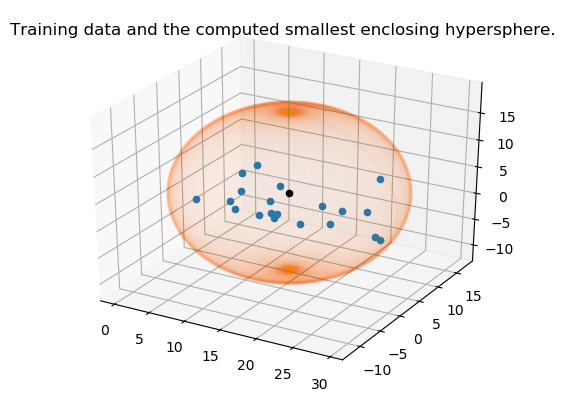

PyObject Text(0.5,0.92,'Training data and the computed smallest enclosing hypersphere.')

In [13]:
# X_train transformed into feature space
phiX_train = ksh.k.ϕ(X_train)
scatter3D(phiX_train[2,:], phiX_train[1,:], phiX_train[3,:],
    depthshade = false)
scatter3D(ksh.c[2,:], ksh.c[1,:], ksh.c[3,:], 
    depthshade = false, c = "black")
ses = sphere(ksh.r, ksh.c, 200)
scatter3D(ses[2,:], ses[1,:], ses[3,:], s= 3, alpha=0.01)
title("Training data and the computed smallest enclosing hypersphere.")

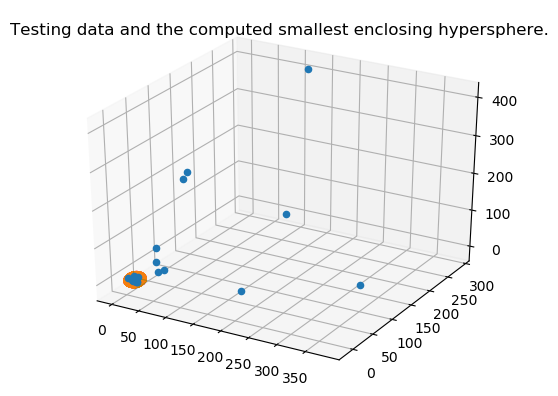

PyObject Text(0.5,0.92,'Testing data and the computed smallest enclosing hypersphere.')

In [14]:
phiX_test = ksh.k.ϕ(X_test)
scatter3D(phiX_test[2,:], phiX_test[1,:], phiX_test[3,:],
    depthshade = false)
scatter3D(ksh.c[2,:], ksh.c[1,:], ksh.c[3,:], 
    depthshade = false, c = "black")
ses = sphere(ksh.r, ksh.c, 200)
scatter3D(ses[2,:], ses[1,:], ses[3,:], s= 3, alpha=0.01)
title("Testing data and the computed smallest enclosing hypersphere.")

# Experiment 2 - MIL data

In the second part of this protocol, we will try to implement and test various kernels for the MIL problem. The implmentation will then be tested on a number of selected benchmark datasets.

## The datasets

We will use the following datasets with different number of features, bags and different average bag size.

In [15]:
using JLD # for data loading
using Distances # for the rbf distance computation
# auxilliary functions for MIL data manipulation
include("/home/vit/Dropbox/vyzkum/cisco/kod/lib/julia/VBMatrixFactorization/examples/mil_util.jl")

plot_statistics

In [16]:
data_path = "./data"
flist = readdir(data_path);
for fname in flist
    fname = split(fname, ".")
    if fname[2] != "jld"
        continue
    else
        fname = fname[1]
    end
    data = load(string(data_path, "/", fname, ".jld"))
    print(fname, ": ", length(unique(data["bagids"])), " bags,", 
        size(data["fMat"])[1], " features, ", 
        round(size(data["fMat"])[2]/length(unique(data["bagids"])), 1), 
        " average bag size\n")
end

BrownCreeper: 548 bags,38 features, 18.7 average bag size
CorelAfrican: 2000 bags,9 features, 4.0 average bag size
CorelBeach: 2000 bags,9 features, 4.0 average bag size
Protein: 193 bags,9 features, 137.9 average bag size
WinterWren: 548 bags,38 features, 18.7 average bag size


## Kernels

We will use a combination of classical kernels (polynomial, RBF, ANOVA) and aggretation methods such as mean, min and max. The aggregation will be done on the space of bags (matrices). It will preserve the dimensionality of the input space but it will aggregate a whole bag (matrix) into a single vector by applying an appropriate function to its columns.

### Polynomial kernel

A general polynomial kernel of order $p$ has the kernel function
$$
    \kappa(x,y) = (\langle x, y \rangle + c)^p.
$$
It is widely used, however large values of $p$ are not usually used as they are prone to overfitting. Also, numerical problems might occur since $\lim_{p \rightarrow \infty} \kappa(x,y) = 0$ for $\langle x, y \rangle < 1$ and $\lim_{p \rightarrow  \infty} \kappa(x,y) = \infty$ for $\langle x, y \rangle > 1$.


We will not implement a feature map for a general polynomial kernel since in the smallest enclosing sphere algorithm it is only needed to obtain the center of the sphere butn ot for the classification. Again, a small number is added to the diagonal of kernel matrix to ameliorate some numerical problems.

In [17]:
struct polykernel <: kernel
    p # polynomial order
    X # the data matrix
    km # kernel matrix
    ϕ # feature map
    c # offset
end

# constructor
polykernel(X, p, c=0) = polykernel(p, X, 
    (X'*X .+ c).^p + eye(size(X,2))*1e-12, # here the noise is added 
    nothing, c)

# overloaded for direct calling
(pk::polykernel)(x,y) = (x'*y + pk.c).^(pk.p)
(pk::polykernel)(x) = pk(x,x)

### RBF (Gaussian) kernel

The radial basis function kernel is one of the most widely used. It has the kernel function
$$
    \kappa(x,y) = \exp \left( -\frac {\langle x -y, x-y \rangle}{2\sigma^2} \right).
$$
Here, $\sigma$ is a parameter that controls the width of the kernel. For small values, it is able to fit individual measurements very well and is thus prone to overfittin. Large values of $\sigma$ tend to smooth out and hide information. It is imperative to choose the optimal value well.

The feature space of an RBF kernel has infinite dimensions (as can be shown using a Taylor expansion of the exponential).

In [18]:
struct rbfkernel <: kernel
    σ # kernel width
    X 
    km
    ϕ
end

# constructor
rbfkernel(X, σ) = rbfkernel(σ, X, 
    exp.(-pairwise(Euclidean(), X, X).^2/(2*σ^2)) + eye(size(X,2))*1e-12,
    nothing)

# overloaded for direct calling
(rk::rbfkernel)(x,y) = exp.(-pairwise(Euclidean(), x, y).^2/(2*rk.σ^2))
(rk::rbfkernel)(x) = rk(x,x)

In [55]:
# we also need to implement a pairwise method for vectors
import Distances.pairwise
pairwise{T<:Real}(dist::Distances.PreMetric, 
    x::AbstractArray{T,1}, y::AbstractArray{T,1}) = euclidean(x,y)
pairwise{T<:Real}(dist::Distances.PreMetric, 
    x::AbstractArray{T,2}, y::AbstractArray{T,1}) = 
    [euclidean(x[:,i],y) for i in 1:size(x,2)]

pairwise (generic function with 4 methods)

### Aggregating functions

First we create a type that represents a collection of bags. It will be the input value to the aggregating functions.

In [19]:
mutable struct mil
    bags # a list of bags
    labels # a vector of labels
    nbags # number of bags
    M # dimension of input space
end

"""
    mil(data)

From data extracted from a jld file, return the mil type.
"""
function mil(data)
    ids = unique(data["bagids"])
    nbags = length(ids)
    labels = zeros(nbags)
    bags = []
    
    for (i, id) in enumerate(ids)
        push!(bags, data["fMat"][:,data["bagids"].==id])
        labels[i] = data["y"][data["bagids"].==id][1]
    end
    
    return mil(bags, labels, nbags, size(bags[1],1))
end

mil(X, y) = mil(X, y, length(X), size(X,1))

mil

Now we write the individual aggregating functions by overloading the classical methods.

In [20]:
import Base: mean, median, maximum, minimum
mean(m::mil) = cat(2, mean.(m.bags,2)...)
median(m::mil) = cat(2, median.(m.bags,2)...)
maximum(m::mil) = cat(2, maximum.(m.bags,2)...)
minimum(m::mil) = cat(2, minimum.(m.bags,2)...)

minimum (generic function with 17 methods)

Also, whitening of the data is very useful

In [21]:
function whiten!(m::mil)
    m.bags = scaleY.(m.bags)
    return m
end

whiten! (generic function with 1 method)

Let's try to classify one dataset by randomly splitting the normal samples in two halves.

In [76]:
# get the data
data = load(joinpath(data_path, flist[1]))
m = mil(data);
m = whiten!(m)

# training data
X_normal = m.bags[m.labels.==0]
y_normal = m.labels[m.labels.==0]
n_normal = length(y_normal)
inds = sample(1:m.nbags, m.nbags, replace=false)
ntrain = Int(round(length(X_normal)/2))
mtrain = mil(X_normal[inds[1:ntrain]], y_normal[inds[1:ntrain]])

# testing data
X_test = X_normal[inds[[ntrain+1:end]]
# also append the anomalies
append!(X_test, m.bags[m.labels.==1]);
y_test = cat(1, y_normal[inds[[ntrain+1:end]], m.labels[m.labels.==1]) 
mtest = mil(X_test, y_test);

LoadError: [91mBoundsError: attempt to access 351-element Array{Array{Float32,2},1} at index [[430, 511, 473, 125, 209, 322, 238, 410, 64, 266, 115, 11, 237, 150, 220, 146, 404, 127, 216, 183, 55, 432, 479, 67, 159, 503, 296, 419, 446, 32, 443, 23, 321, 349, 50, 535, 468, 456, 427, 28, 44, 3, 345, 523, 200, 210, 357, 326, 541, 470, 405, 25, 525, 529, 6, 311, 495, 491, 91, 88, 295, 344, 275, 99, 474, 135, 329, 411, 388, 378, 437, 267, 130, 122, 298, 465, 520, 309, 204, 447, 313, 362, 182, 279, 46, 304, 517, 110, 425, 223, 307, 512, 515, 178, 124, 346, 242, 360, 476, 9, 504, 463, 232, 354, 52, 315, 56, 374, 29, 207, 352, 190, 440, 422, 147, 368, 444, 361, 73, 27, 167, 291, 480, 1, 69, 286, 249, 532, 247, 534, 496, 192, 415, 339, 539, 382, 102, 86, 471, 426, 141, 186, 519, 118, 201, 369, 181, 145, 305, 213, 265, 105, 531, 66, 314, 328, 218, 336, 94, 348, 157, 51, 128, 229, 179, 412, 340, 299, 117, 312, 106, 156, 230, 257, 172, 380]][39m

548-element Array{Int64,1}:
 211
 205
 435
 531
 308
 257
 526
  89
 290
  81
 107
 277
 316
   ⋮
 422
  65
  12
  24
 126
 283
 219
 130
  57
 397
 534
 532

In [48]:
# now construct a kernel, compute the hypersphere and score 
# the testing dataset
#ksh = kernel_sh(polykernel(mean(mtrain), 2, 0););
ksh = kernel_sh(rbfkernel(mean(mtrain), 1e-7););
find_sphere!(ksh)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 31510
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 179, constraints m = 359
Cones:	primal zero / dual free vars: 2
	linear vars: 177
	soc vars: 180, soc blks: 2
Setup time: 1.09e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  4.35e-04 
   100| 6.99e-03  3.97e-01  5.00e-02 -8.61e-01 -1.00e+00  0.00e+00  2.78e-02 
   200| 9.80e-04  1.55e-01  2.55e-02 -8.44e-01 -7.77e-01  0.00e+00  4.49e-02 
   300| 6.27e-04  5.91e-

Produce the anomaly scores for testing inputs. Last inputs are anomalies - they should have a higher anomaly score.

In [62]:
X_test = mean(mtest)
ascore = anomaly_score(ksh, X_test)

372-element Array{Float64,1}:
 -0.0847213 
 -0.0968626 
 -0.00202528
  0.0772807 
 -0.0580467 
 -0.14301   
 -0.144952  
 -0.15625   
 -0.24278   
 -0.0387517 
 -0.0995249 
 -0.0933128 
 -0.0900704 
  ⋮         
 -0.105552  
 -0.122239  
 -0.0261945 
 -0.0179696 
  0.00503724
  0.0635122 
 -0.0846587 
 -0.0341616 
  0.0205021 
 -0.0106622 
 -0.114748  
 -0.0207095 

Now try to draw an ROC curve and compute AUROC. Here the ROC is constructed by ordering the samples by their anomaly score. We start in the upper right corner and go by the samples - ideally, all negative samples should be ordered first. When there is a mistake, we decrease the tru positive rate. False negative rate is decreased by every asmple.

In [66]:
# include a proper library
using EvalCurves
using PyPlot

In [71]:
tprvec, fprvec = EvalCurves.roccurve(ascore, mtest.labels)
auroc = EvalCurves.auc(fprvec, tprvec)
println("AUROC = $auroc")

AUROC = 0.7430601885424185


In [73]:
display(EvalCurves.plotroc([(fprvec, tprvec, "mean-rbf-1e-7")]...))